<a href="https://colab.research.google.com/github/mavivi95/overfittingLipschitzBound/blob/main/validationMethodLBExperimentoAadvPGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Add

from numpy.linalg import norm
import pandas as pd

import sklearn.metrics

from keras import regularizers as l

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

import os

from matplotlib.ticker import FormatStrFormatter

import time
np.random.seed(2023)

In [ ]:
print(os.getcwd())

/content


In [ ]:
os.chdir('/content/drive/MyDrive/Tesis Maestría /Codigos depurados/Experimento Imagenes Adversarias A')
print(os.getcwd())

In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
def load_data():
  mnist = keras.datasets.mnist
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train, X_test = X_train / 255.0, X_test / 255.0
  X_train = X_train.reshape(len(y_train),784)
  X_test  = X_test.reshape(len(y_test),784)

  y_train_onehot = keras.utils.to_categorical(y_train)
  y_test_onehot =  keras.utils.to_categorical(y_test)

  print(f'Conjunto de datos cargados')
  print(f'Tamaño imágenes de entrenamiento {X_train[:10000].shape}')
  print(f'Tamaño imágenes de test {X_test.shape}')
  print(f'Datos por cada etiqueta en X train {np.bincount(y_train[:10000])}')
  return X_train[:10000], X_test, y_train_onehot[:10000], y_test_onehot, y_train[:10000], y_test

In [ ]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Conjunto de datos cargados
Tamaño imágenes de entrenamiento (10000, 784)
Tamaño imágenes de test (10000, 784)
Datos por cada etiqueta en X train [1001 1127  991 1032  980  863 1014 1070  944  978]


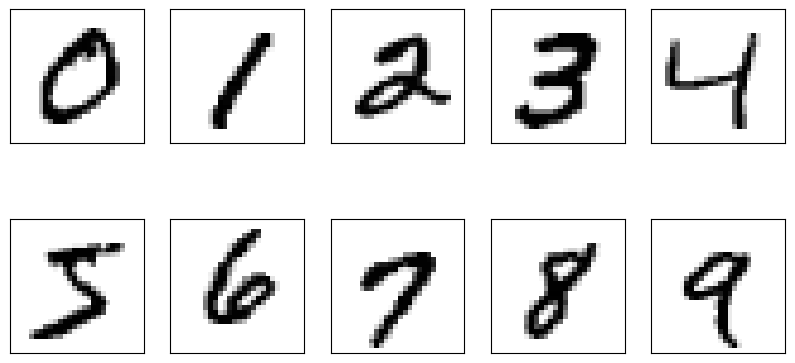

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gist_yarg')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

## Modelo con $n$ saltos residuales

In [ ]:
def skip_conection(dense_input, n, regular_l):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    return skip_conection(Add()([dense_input, resDense]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  return Add()([dense_input, resDenseo])

In [ ]:
def load_model(n, regular_l):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20, activation  ='relu', kernel_regularizer=regular_l)(inputs)

  skip_final = skip_conection(dense1, n, regular_l)

  outputs = Dense(10, activation='softmax', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=100, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)

        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

In [ ]:
generator = DataGenerator(images=X_train, labels=y_train, batch_size=100, shuffle=True)
n_batches = len(generator)
n_batches

100

In [ ]:
def lipschitz_bound(modelWeigts):
  numberLayers = len(modelWeigts)
  LipsBound = np.linalg.norm(modelWeigts[0], ord=2)     # Norma espectral (2) capa 1
  if LipsBound == 0: LipsBound = 1

  for rc in np.arange(2,numberLayers-2,2):              # En los indices de las capas residuales
    try:
      LipsBound *= (1 + np.linalg.norm(modelWeigts[rc], ord=2))
    except:
      LipsBound *= 1

  LipsBound *= np.linalg.norm(modelWeigts[numberLayers-2], ord=2) # Capa de salida

  return  LipsBound

##  Funciones graficar

In [ ]:
def graphGridAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271',
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0,
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0,
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.grid()
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.tight_layout()
  nameFile = 'presicionModelo' + str(skip) + 'G' +'.pdf'
  plt.savefig(nameFile)
  #plt.show()



def graphAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271',
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0,
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0,
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  nameFile = 'presicionModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile)
  #plt.show()


In [ ]:
def graphGridLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0,
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  nameFile = 'cotaLipschitzModelo' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile)
  #plt.show()

def graphLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0,
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelo' + str(skip) +'.pdf'
  plt.savefig(nameFile)
  #plt.show()

In [ ]:
def graphGridLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0),
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelolog' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile)
  #plt.show()

def graphLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0),
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  nameFile = 'cotaLipschitzModelolog' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile)
  #plt.show()

In [ ]:
def graphGridLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0,
                  label = r'$\sigma$ perdida en entrenamiento',
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación',
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val,
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'funcionPerdidaModelo' + str(skip) + 'G' + '.pdf'
  plt.tight_layout()
  plt.savefig(nameFile)
  #plt.show()

def graphLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0,
                  label = r'$\sigma$ perdida en entrenamiento',
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación',
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val,
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  nameFile = 'funcionPerdidaModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile)
  #plt.show()


## Entrenamiento conjunto de modelos validación cruzada k-fold - Entrenamiento Convencional

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneral = {}
modelConvencional = {}

for skip in skips:
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')
  generator = DataGenerator(images=X_train,
                            labels=y_train,
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)

  model = load_model(skip,l.l2(0))

  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))

  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
    for batch in range(n_batches):
      x, y = generator[batch]

      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)

      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))

    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB = lipschitz_bound(model.get_weights())
    LB_1[epoch]= LB

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test,
                                                      y_pred=np.argmax(y_test_, axis=-1))

  resultGeneral[skip] = [acc_train, acc_test, LB_1]
  modelConvencional[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneral), 'ResultadosExperimentoAadv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = resultGeneral[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 92.42
Modelo 6, test 91.93
Modelo 8, test 91.20


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = resultGeneral[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 96.42
Modelo 6, train 97.80
Modelo 8, train 97.10


### Evaluación con imágenes adversarias PGD

In [ ]:
# PGD Attack Implementation
def pgd_attack(x, y, model, epsilon=0.03, alpha=0.01, iterations=10):
    x_adv = tf.Variable(x)
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            prediction = model(x_adv)
            loss = keras.losses.categorical_crossentropy(y, prediction)
        gradient = tape.gradient(loss, x_adv)
        signed_grad = tf.sign(gradient)
        x_adv.assign_add(alpha * signed_grad)

        # Project perturbations to ensure they stay within epsilon bounds
        perturbation = tf.clip_by_value(x_adv - x, -epsilon, epsilon)
        x_adv.assign(x + perturbation)

    return x_adv.numpy()

# Function to scale images
def scale_image(x):
    m = 1 / (np.max(x) - np.min(x))
    b = -1 * m * np.min(x)
    return m * x + b * np.ones(len(x))

# Function to plot digits
def graph_digits(X, y):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))
    ax = ax.flatten()
    for i in range(10):
        img = X[y == i][0].reshape(28, 28)
        ax[i].imshow(img, cmap='gist_yarg')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.show()

Original Images


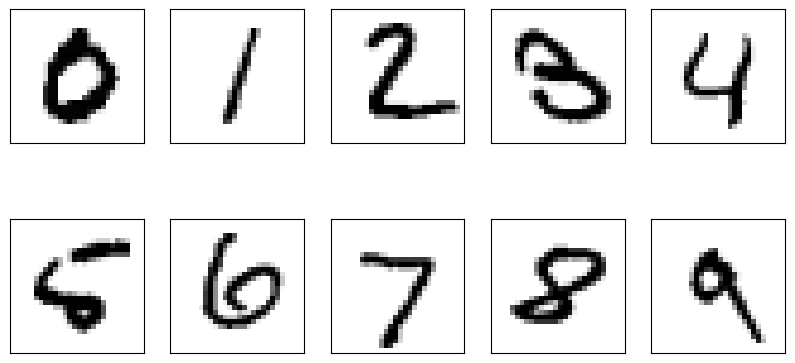

In [ ]:
# Display original images
print("Original Images")
graph_digits(X_test[0:1000], y_test[0:1000])

Perturbed Images Example


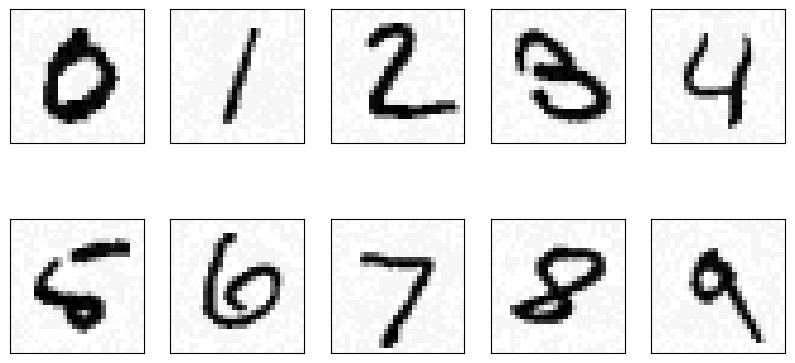

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Perturbed Images Example


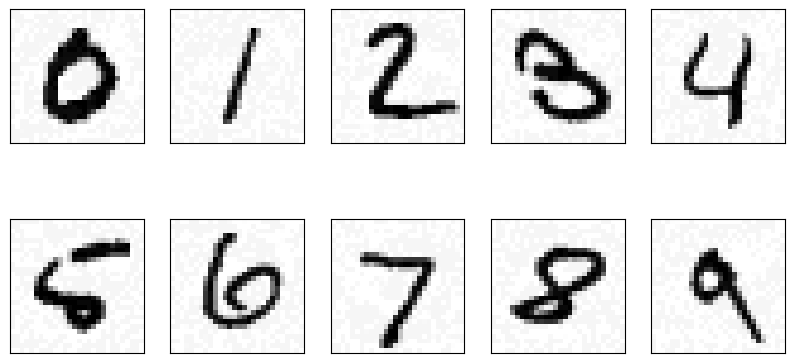

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Perturbed Images Example


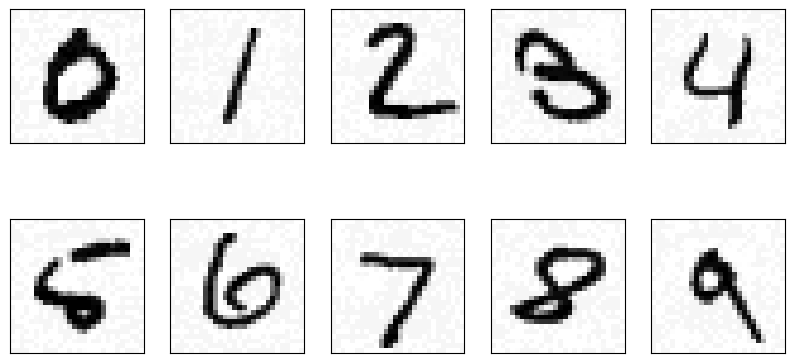

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Loss function
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}

for skip in skips:
    rho = 0.02
    Eval_models_by_rho = {}
    model = modelConvencional[skip]

    X_test_attack = np.zeros((1000, 784))
    i = 0

    for x_test in X_test[0:1000]:
        x_tensor = tf.convert_to_tensor(x_test, dtype='float32')
        x_tensor = tf.expand_dims(x_tensor, axis=0)
        y_tensor = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
        y_tensor = tf.expand_dims(y_tensor, axis=0)

        # Generate adversarial example with PGD
        x_test_new = pgd_attack(x_tensor, y_tensor, model, epsilon=rho, alpha=0.005, iterations=10)
        X_test_attack[i] = scale_image(x_test_new)
        i += 1

    print(f'Perturbed Images Example')
    graph_digits(X_test_attack, y_test[0:1000])

    # Evaluate the model on adversarial examples
    y_pred = model.predict(X_test_attack)
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_pred, axis=-1))
    Eval_models_by_rho_skip[skip] = Eval_models

In [ ]:
for skip in skips:
    print(f'Modelo {skip}, % presición {Eval_models_by_rho_skip[skip]*100:0.2f}')

Modelo 4, % presición 41.90
Modelo 6, % presición 34.30
Modelo 8, % presición 28.00


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización Alternante cota Lipschitz

In [ ]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, Model=None, name="adaptativeRegularLB"):
        super().__init__(name=name)
        self.Model = Model

    def call(self, y_true, y_pred):
        cce = tf.keras.losses.CategoricalCrossentropy()
        loss = tf.cast(cce(y_true, y_pred), tf.float32)
        loss += self.eig_values_random()  # Ahora devuelve un tensor y lo suma directamente
        return loss

    def eig_values_random(self):
        allLayers = self.Model.layers
        nLayers = len(allLayers)

        # Evita errores si hay pocas capas
        if nLayers < 3:
            return tf.constant(0.0, dtype=tf.float32)  # Devuelve un tensor de cero en caso de error

        # Seleccionar una capa aleatoria (excluyendo la de entrada)
        randomLayer = np.random.choice(np.concatenate(([1], np.arange(2, nLayers, 2))), size=1)[0]

        # Verificar si la capa tiene pesos antes de calcular su norma espectral
        if len(allLayers[randomLayer].get_weights()) > 0:
            EigVal = np.linalg.norm(allLayers[randomLayer].get_weights()[0], ord=2)
            EigVal = tf.convert_to_tensor(EigVal, dtype=tf.float32)

            # Verificar si la capa tiene variables entrenables antes de agregar la pérdida
            if len(allLayers[randomLayer].trainable_variables) > 0:
                norm_value = tf.norm(allLayers[randomLayer].trainable_variables[0], ord=2)
                return EigVal * norm_value  # Devuelve el valor de pérdida en lugar de usar add_loss()

        return tf.constant(0.0, dtype=tf.float32)

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneralLB = {}
modelLB = {}
for skip in skips:

  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')
  generator = DataGenerator(images=X_train,
                            labels=y_train,
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_model(skip,l.l2(0))


  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))

  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
    for batch in range(n_batches):
      x, y = generator[batch]

      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        lossC = CustomLoss(Model = model)
        loss = lossC(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)

      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))

    generator.on_epoch_end()

    acc_train[epoch] = epoch_acc_avg.result()

    LB = lipschitz_bound(model.get_weights())
    LB_1[epoch]= LB

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test,
                                                      y_pred=np.argmax(y_test_, axis=-1))
  resultGeneralLB[skip] = [acc_train, acc_test, LB_1]
  modelLB[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralLB), 'ResultadosExperimentoALBadv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = resultGeneralLB[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 88.98
Modelo 6, test 90.02
Modelo 8, test 91.93


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = resultGeneralLB[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 90.11
Modelo 6, train 91.82
Modelo 8, train 94.27


### Evaluación con imágenes adversarias

Imagenes originales


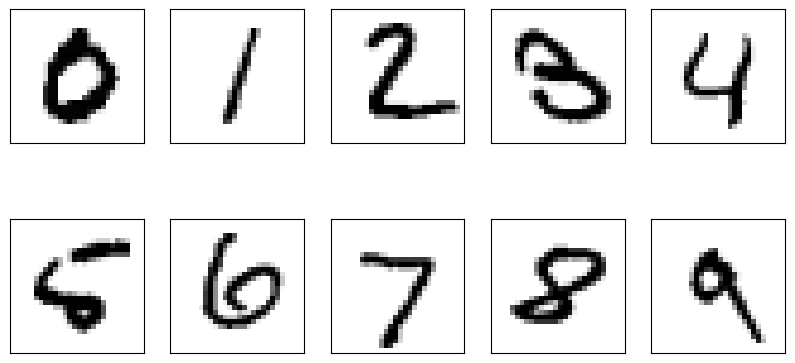

Perturbed Images Example


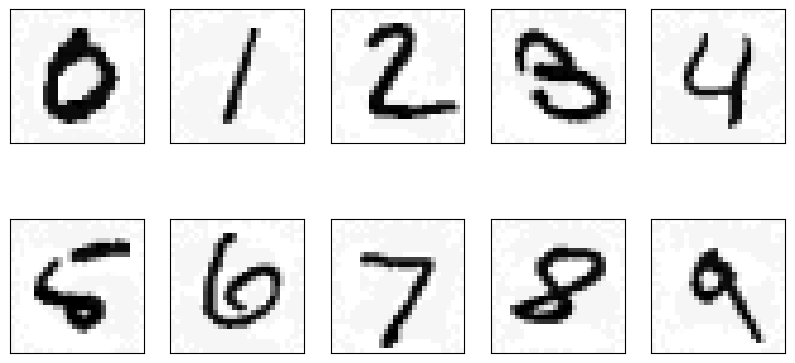

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Perturbed Images Example


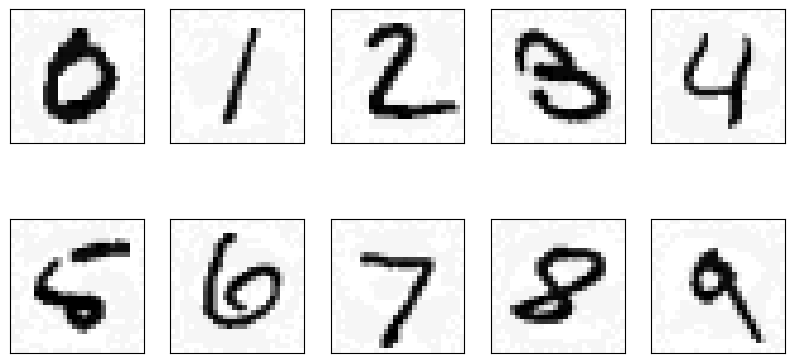

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Perturbed Images Example


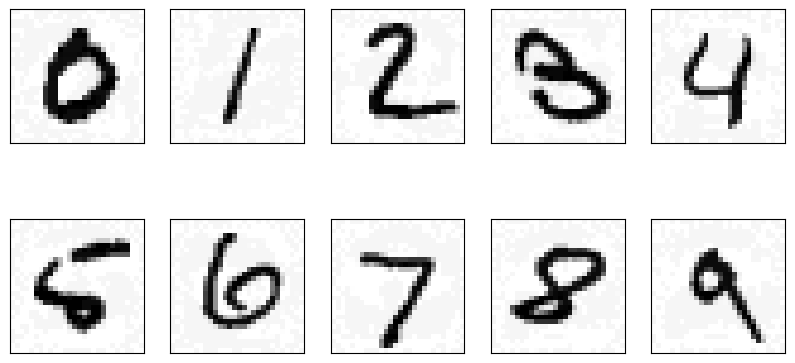

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])

# Loss function
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}

for skip in skips:
    rho = 0.02
    Eval_models_by_rho = {}
    model = modelLB[skip]

    X_test_attack = np.zeros((1000, 784))
    i = 0

    for x_test in X_test[0:1000]:
        x_tensor = tf.convert_to_tensor(x_test, dtype='float32')
        x_tensor = tf.expand_dims(x_tensor, axis=0)
        y_tensor = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
        y_tensor = tf.expand_dims(y_tensor, axis=0)

        # Generate adversarial example with PGD
        x_test_new = pgd_attack(x_tensor, y_tensor, model, epsilon=rho, alpha=0.005, iterations=10)
        X_test_attack[i] = scale_image(x_test_new)
        i += 1

    print(f'Perturbed Images Example')
    graph_digits(X_test_attack, y_test[0:1000])

    # Evaluate the model on adversarial examples
    y_pred = model.predict(X_test_attack)
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_pred, axis=-1))
    Eval_models_by_rho_skip[skip] = Eval_models

In [ ]:
for skip in skips:
    print(f'Modelo {skip},  % presición {Eval_models_by_rho_skip[skip]*100:0.2f}')

Modelo 4,  % presición 77.20
Modelo 6,  % presición 74.30
Modelo 8,  % presición 74.30


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L2

### Sintonización hiper-parámetro

In [ ]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ l.l2(0.1), l.l2(0.01), l.l2(0.001), l.l2(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l2}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train):
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
      model.fit(X_train[train_index],
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.10000000149011612
Kfold 1 acc train 0.8376250267028809, acc test 0.8159999847412109
Kfold 2 acc train 0.8458750247955322, acc test 0.8569999933242798
Kfold 3 acc train 0.8413749933242798, acc test 0.840499997138977
Kfold 4 acc train 0.8322499990463257, acc test 0.824999988079071
Kfold 5 acc train 0.8481249809265137, acc test 0.8264999985694885
Fin modelo: promedio acc train 0.8410500049591064,std 0.005702846638642575
Fin modelo: promedio acc test 0.8329999923706055,std 0.014335273731467877


Modelo 4, parametro 0.009999999776482582
Kfold 1 acc train 0.9448750019073486, acc test 0.906000018119812
Kfold 2 acc train 0.9430000185966492, acc test 0.9309999942779541
Kfold 3 acc train 0.9512500166893005, acc test 0.9315000176429749
Kfold 4 acc train 0.937125027179718, acc test 0.9160000085830688
Kfold 5 acc train 0.9512500166893005, acc test 0.9120000004768372
Fin modelo: promedio acc train 0.9455000162124634,std 0.005346140350318817
Fin modelo: promedio acc test 0.91930

In [ ]:
regularParameters = {4: l.l2(0.001), 6: l.l2(0.001), 8: l.l2(0.01)}
regularParameters

{4: <keras.src.regularizers.regularizers.L2 at 0x78f6616d2c10>,
 6: <keras.src.regularizers.regularizers.L2 at 0x78f661686c10>,
 8: <keras.src.regularizers.regularizers.L2 at 0x78f66173cf10>}

### Entrenamiento

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneralL2 = {}
modelL2 = {}

for skip in skips:

  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\nIniciando Entrenamiento')
  print(f'\n ----')

  generator = DataGenerator(images=X_train,
                            labels=y_train,
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_model(skip,regularParameters[skip])
  model.compile(optimizer=optimizer,
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics =['accuracy'])

  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))

  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean()

    for batch in range(n_batches):
      x, y = generator[batch]
      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        loss += tf.add_n(model.losses)
      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))

    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB_1[epoch] = lipschitz_bound(model.get_weights())

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test,
                                                    y_pred=np.argmax(y_test_, axis=-1))

  resultGeneralL2[skip] = [acc_train, acc_test, LB_1]
  modelL2[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL2), 'ResultadosExperimentoAL2adv.csv')

Modelo : 4 saltos residuales

Iniciando Entrenamiento

 ----
100
Modelo : 6 saltos residuales

Iniciando Entrenamiento

 ----
100
Modelo : 8 saltos residuales

Iniciando Entrenamiento

 ----
100


### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = resultGeneralL2[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 92.99
Modelo 6, test 91.70
Modelo 8, test 92.39


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = resultGeneralL2[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 96.84
Modelo 6, train 97.21
Modelo 8, train 96.23


### Evaluación con imágenes adversarias

Imagenes originales


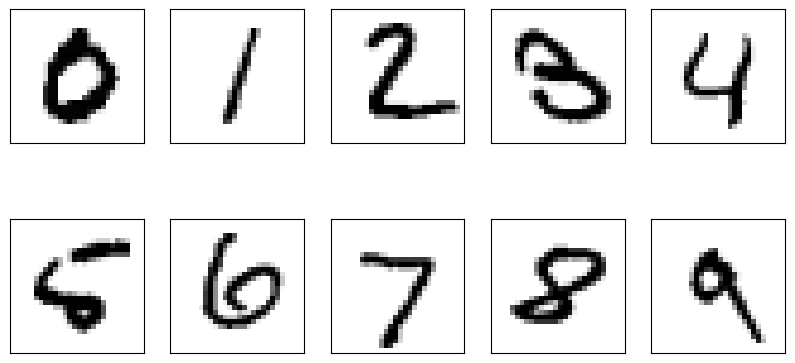

Perturbed Images Example


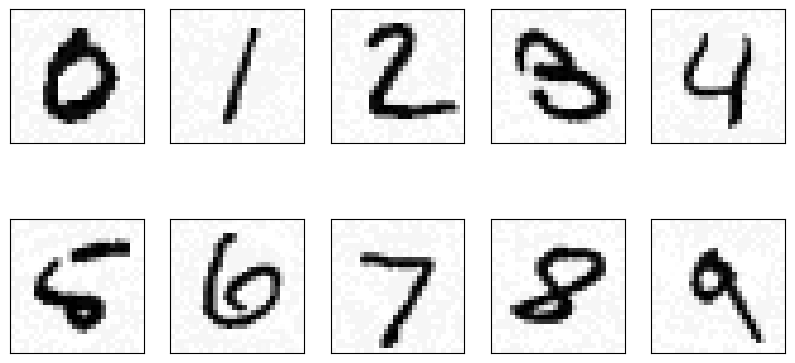

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Perturbed Images Example


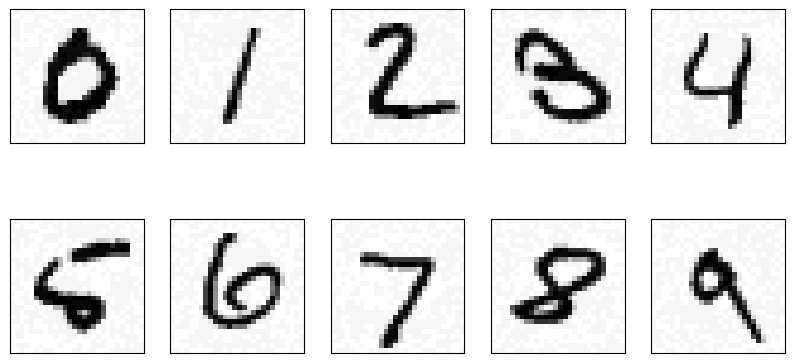

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Perturbed Images Example


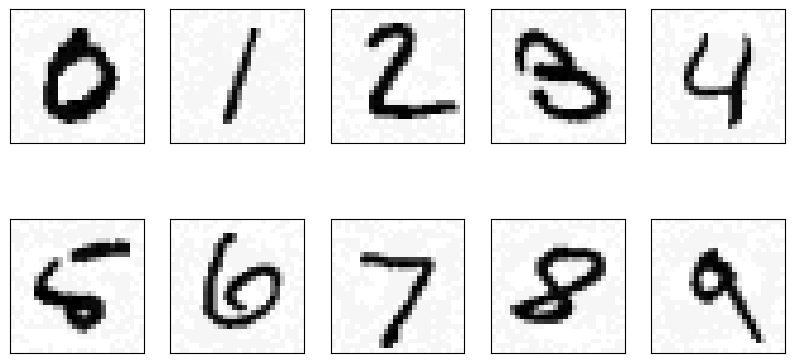

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])

# Loss function
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}

for skip in skips:
    rho = 0.02
    Eval_models_by_rho = {}
    model = modelL2[skip]

    X_test_attack = np.zeros((1000, 784))
    i = 0

    for x_test in X_test[0:1000]:
        x_tensor = tf.convert_to_tensor(x_test, dtype='float32')
        x_tensor = tf.expand_dims(x_tensor, axis=0)
        y_tensor = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
        y_tensor = tf.expand_dims(y_tensor, axis=0)

        # Generate adversarial example with PGD
        x_test_new = pgd_attack(x_tensor, y_tensor, model, epsilon=rho, alpha=0.005, iterations=10)
        X_test_attack[i] = scale_image(x_test_new)
        i += 1

    print(f'Perturbed Images Example')
    graph_digits(X_test_attack, y_test[0:1000])

    # Evaluate the model on adversarial examples
    y_pred = model.predict(X_test_attack)
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_pred, axis=-1))
    Eval_models_by_rho_skip[skip] = Eval_models

In [ ]:
for skip in skips:
    print(f'Modelo {skip}, % presición {Eval_models_by_rho_skip[skip]*100:0.2f}')

Modelo 4, % presición 47.70
Modelo 6, % presición 35.20
Modelo 8, % presición 62.30


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L1

### Sintonización hiper-parámetro

In [ ]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ l.l1(0.1), l.l1(0.01), l.l1(0.001), l.l1(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l1}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train):
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
      model.fit(X_train[train_index],
                y_train_onehot[train_index],
                epochs = 60, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.10000000149011612
Kfold 1 acc train 0.11337500065565109, acc test 0.10999999940395355
Kfold 2 acc train 0.11287499964237213, acc test 0.1120000034570694
Kfold 3 acc train 0.11249999701976776, acc test 0.11349999904632568
Kfold 4 acc train 0.11150000244379044, acc test 0.11749999970197678
Kfold 5 acc train 0.1132500022649765, acc test 0.11050000041723251
Fin modelo: promedio acc train 0.11270000040531158,std 0.0006736094682305085
Fin modelo: promedio acc test 0.11270000040531158,std 0.002694438425944872


Modelo 4, parametro 0.009999999776482582
Kfold 1 acc train 0.8958749771118164, acc test 0.8634999990463257
Kfold 2 acc train 0.8834999799728394, acc test 0.8769999742507935
Kfold 3 acc train 0.9014999866485596, acc test 0.8920000195503235
Kfold 4 acc train 0.8878750205039978, acc test 0.871999979019165
Kfold 5 acc train 0.8891249895095825, acc test 0.8615000247955322
Fin modelo: promedio acc train 0.8915749907493591,std 0.0063544238330290916
Fin modelo: promedio a

In [ ]:
regularParameters = {4: l.l1(0.0001), 6: l.l1(0.001), 8: l.l1(0.001)}
regularParameters

{4: <keras.src.regularizers.regularizers.L1 at 0x78f662788850>,
 6: <keras.src.regularizers.regularizers.L1 at 0x78f6634971d0>,
 8: <keras.src.regularizers.regularizers.L1 at 0x78f68473c590>}

### Entrenamiento

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneralL1 = {}
modelL1 = {}

for skip in skips:

  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')

  generator = DataGenerator(images=X_train,
                            labels=y_train,
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_model(skip,regularParameters[skip])
  model.compile(optimizer=optimizer,
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics =['accuracy'])

  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))

  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean()

    for batch in range(n_batches):
      x, y = generator[batch]
      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        loss += tf.add_n(model.losses)
      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))

    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB_1[epoch] = lipschitz_bound(model.get_weights())

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test,
                                                    y_pred=np.argmax(y_test_, axis=-1))

  resultGeneralL1[skip] = [acc_train, acc_test, LB_1]
  modelL1[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL1), 'ResultadosExperimentoAL1adv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = resultGeneralL1[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 92.68
Modelo 6, test 92.62
Modelo 8, test 91.73


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = resultGeneralL1[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 97.30
Modelo 6, train 97.16
Modelo 8, train 95.81


### Evaluación con imágenes adversarias

Imagenes originales


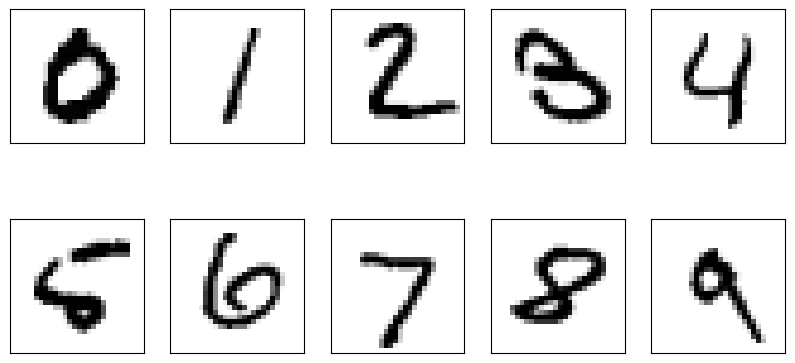

Perturbed Images Example


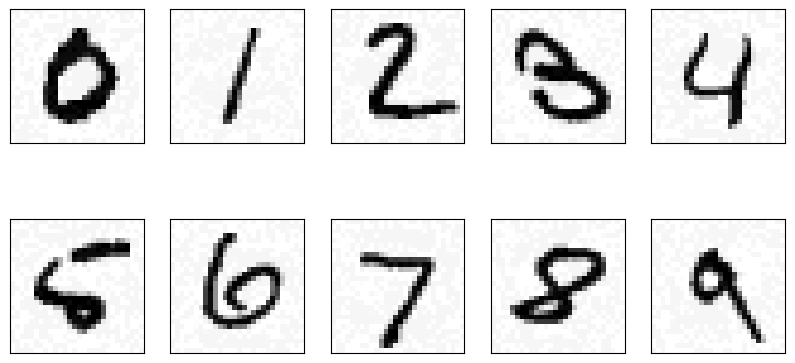

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Perturbed Images Example


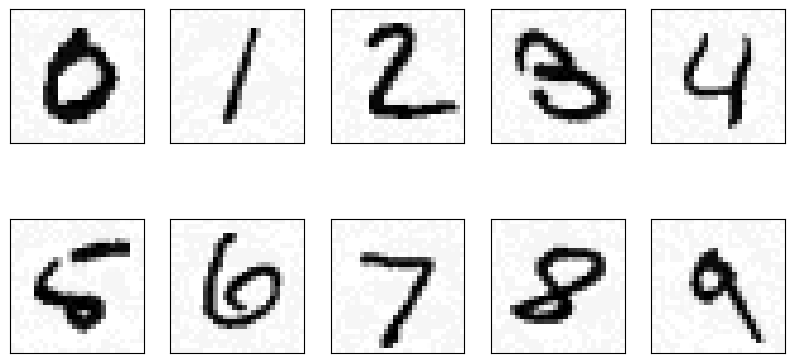

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Perturbed Images Example


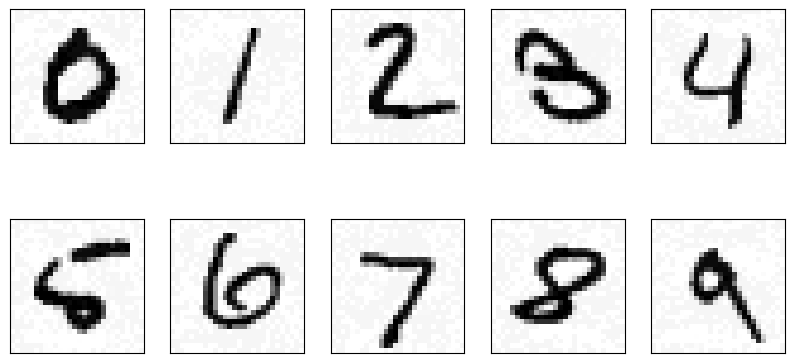

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])

# Loss function
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}

for skip in skips:
    rho = 0.02
    Eval_models_by_rho = {}
    model = modelL1[skip]

    X_test_attack = np.zeros((1000, 784))
    i = 0

    for x_test in X_test[0:1000]:
        x_tensor = tf.convert_to_tensor(x_test, dtype='float32')
        x_tensor = tf.expand_dims(x_tensor, axis=0)
        y_tensor = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
        y_tensor = tf.expand_dims(y_tensor, axis=0)

        # Generate adversarial example with PGD
        x_test_new = pgd_attack(x_tensor, y_tensor, model, epsilon=rho, alpha=0.005, iterations=10)
        X_test_attack[i] = scale_image(x_test_new)
        i += 1

    print(f'Perturbed Images Example')
    graph_digits(X_test_attack, y_test[0:1000])

    # Evaluate the model on adversarial examples
    y_pred = model.predict(X_test_attack)
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_pred, axis=-1))
    Eval_models_by_rho_skip[skip] = Eval_models

In [ ]:
for skip in skips:
    print(f'Modelo {skip}, % presición {Eval_models_by_rho_skip[skip]*100:0.2f}')

Modelo 4, % presición 37.70
Modelo 6, % presición 66.20
Modelo 8, % presición 65.60


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método *Dropout*

### Modelo DropOut

In [ ]:
from keras.layers import Dropout

def skip_conectionDropOut(dense_input, n, regular_l, probabilityDrop):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    resDenseDropOut = Dropout((probabilityDrop))(resDense)
    return skip_conection(Add()([dense_input, resDenseDropOut]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  resDenseoDropOut = Dropout((probabilityDrop))(resDenseo)
  return Add()([dense_input, resDenseo])

In [ ]:
def load_modelDropOut(n, regular_l, probabilityDrop):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20,  activation  ='relu', kernel_regularizer=regular_l)(inputs)
  dense1DropOut = Dropout((probabilityDrop))(dense1)
  skip_final = skip_conectionDropOut(dense1DropOut, n, regular_l, probabilityDrop)

  outputs = Dense(10, activation='sigmoid', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

### Sintonización hiper-parámetro

In [ ]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ 0.2, 0.4, 0.6, 0.8]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train):
      model = load_modelDropOut(skip, l.l2(0), param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
      model.fit(X_train[train_index],
                y_train_onehot[train_index],
                epochs = 60, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.2
Kfold 1 acc train 0.9818750023841858, acc test 0.9194999933242798
Kfold 2 acc train 0.9763749837875366, acc test 0.934499979019165
Kfold 3 acc train 0.972000002861023, acc test 0.9225000143051147
Kfold 4 acc train 0.9796249866485596, acc test 0.9294999837875366
Kfold 5 acc train 0.9753749966621399, acc test 0.9154999852180481
Fin modelo: promedio acc train 0.977049994468689,std 0.0034256374128069345
Fin modelo: promedio acc test 0.9242999911308288,std 0.006852731953505545


Modelo 4, parametro 0.4
Kfold 1 acc train 0.8653749823570251, acc test 0.8195000290870667
Kfold 2 acc train 0.9470000267028809, acc test 0.9164999723434448
Kfold 3 acc train 0.9522500038146973, acc test 0.9085000157356262
Kfold 4 acc train 0.956250011920929, acc test 0.9164999723434448
Kfold 5 acc train 0.9383749961853027, acc test 0.890500009059906
Fin modelo: promedio acc train 0.931850004196167,std 0.03377143050666077
Fin modelo: promedio acc test 0.8902999997138977,std 0.03665185823193100

In [ ]:
regularParameters = {4: 0.2, 6: 0.2, 8: 0.2}
regularParameters

{4: 0.2, 6: 0.2, 8: 0.2}

### Entrenamiento

In [ ]:
skips = [4,6,8]
n_epochs = 60
resultGeneralDO = {}
modelDO = {}

for skip in skips:

  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')

  generator = DataGenerator(images=X_train,
                            labels=y_train,
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_modelDropOut(skip,l.l2(0),regularParameters[skip])
  model.compile(optimizer=optimizer,
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics =['accuracy'])

  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))

  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean()

    for batch in range(n_batches):
      x, y = generator[batch]

      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)

      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))

    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB_1[epoch] = lipschitz_bound(model.get_weights())

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test,
                                                    y_pred=np.argmax(y_test_, axis=-1))

  resultGeneralDO[skip] = [acc_train, acc_test, LB_1]
  modelDO[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralDO), 'ResultadosExperimentoADOadv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = resultGeneralDO[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 90.80
Modelo 6, test 91.73
Modelo 8, test 90.68


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = resultGeneralDO[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 88.86
Modelo 6, train 90.83
Modelo 8, train 88.88


### Evaluación con imágenes adversarias

Imagenes originales


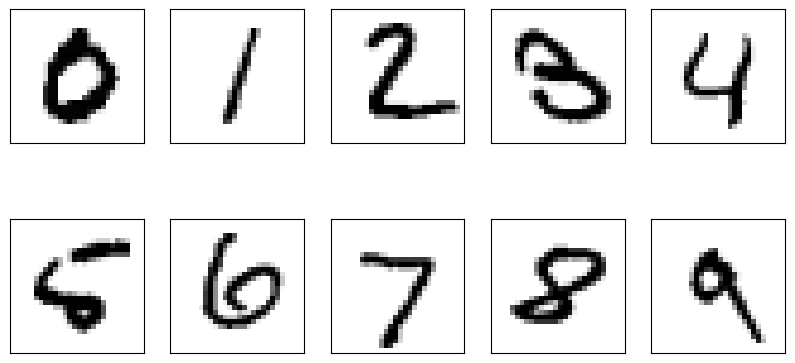

Perturbed Images Example


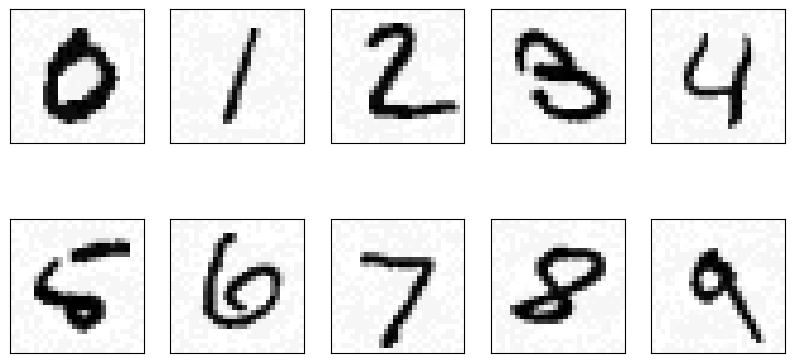

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Perturbed Images Example


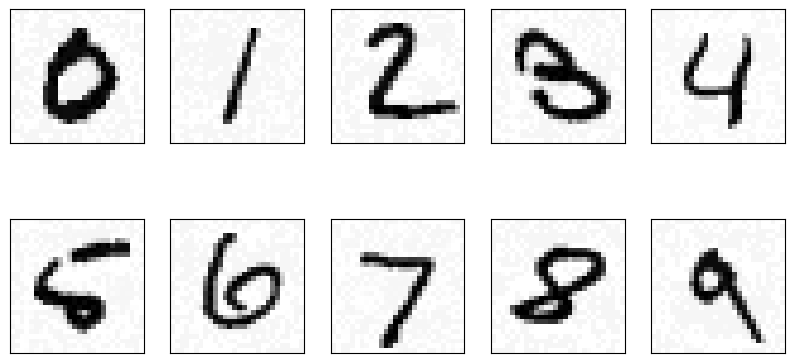

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Perturbed Images Example


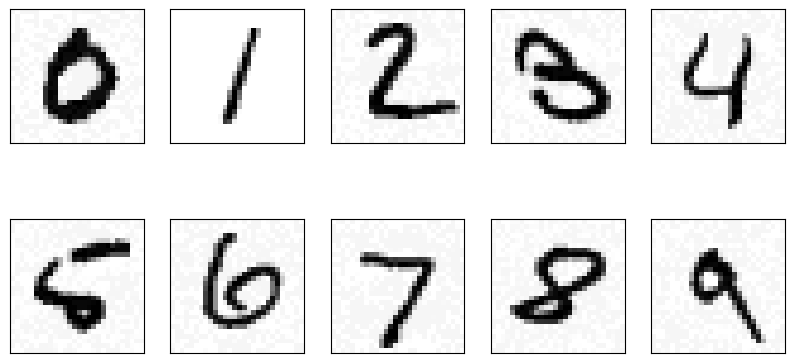

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])

# Loss function
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}

for skip in skips:
    rho = 0.02
    Eval_models_by_rho = {}
    model = modelDO[skip]

    X_test_attack = np.zeros((1000, 784))
    i = 0

    for x_test in X_test[0:1000]:
        x_tensor = tf.convert_to_tensor(x_test, dtype='float32')
        x_tensor = tf.expand_dims(x_tensor, axis=0)
        y_tensor = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
        y_tensor = tf.expand_dims(y_tensor, axis=0)

        # Generate adversarial example with PGD
        x_test_new = pgd_attack(x_tensor, y_tensor, model, epsilon=rho, alpha=0.005, iterations=10)
        X_test_attack[i] = scale_image(x_test_new)
        i += 1

    print(f'Perturbed Images Example')
    graph_digits(X_test_attack, y_test[0:1000])

    # Evaluate the model on adversarial examples
    y_pred = model.predict(X_test_attack)
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_pred, axis=-1))
    Eval_models_by_rho_skip[skip] = Eval_models

In [ ]:
for skip in skips:
    print(f'Modelo {skip}, % presición {Eval_models_by_rho_skip[skip]*100:0.2f}')

Modelo 4, % presición 56.50
Modelo 6, % presición 49.40
Modelo 8, % presición 46.50
